# Task Assignment Resilience Analysis

In [25]:
%reload_ext autoreload
%autoreload 2
from matplotlib.cm import viridis
from matplotlib.colors import PowerNorm
from matplotlib.pyplot import rcParams, subplots
from matplotlib.ticker import MultipleLocator, PercentFormatter
from multiprocessing import Pool
from numpy import linspace, logspace
from numpy.random import default_rng
from pandas import concat
from seaborn import kdeplot
from tqdm import tqdm
from taadaptivity.model import TaskModel, EXAMPLE_PARAMS

rcParams["figure.figsize"] = [10, 5]


# Parameters
RNG = default_rng(98820557)
NUM_REPS = 500
PARAMS = EXAMPLE_PARAMS["REGULAR"]
SIGMAS = linspace(0, 22, 50)
N_CORES = 12


# Helpers
def sample_seed(rng, size = None):
    """Use the given RNG to sample new seeds for other numpy RNGs."""
    return rng.integers(2**63, size = size)

## Tasks per Agent over Time

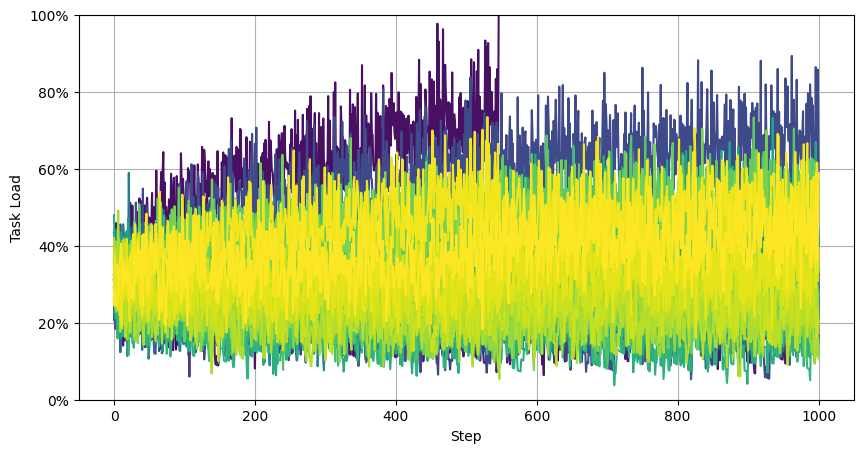

In [2]:
# Run ABM
abm = TaskModel(**PARAMS)
abm.run_model()

# Plot measured agent load
#     .unstack transforms into rows=timestep, cols=AgentIDs, and .line plots
#     columns as separate lines.
agent_df = abm.datacollector.get_agent_vars_dataframe()
axes = agent_df.unstack().plot.line(cmap = viridis, ylabel = "Task Load", ylim = (0, 1),
                                    legend = False, grid = True)
axes.yaxis.set_major_formatter(PercentFormatter(1))  # see: https://stackoverflow.com/a/36319915

Note that agents fail when reaching a task load of 100%.
The plot shows them as curves that disappear after a certain step.

## Agent Failure vs. Heterogeneity Plot 

In [3]:
# Simulation helpers

def abm_factory(num_reps, num_steps, sigmas, fixed_params, rng):
    """Yield the kwargs for TaskModel.__init__ to implement the provided parameter sweep."""
    for sigma in sigmas:
        for rep_id in range(num_reps):
            params = fixed_params.copy()
            params["sigma"] = sigma
            yield {"params": params, "max_steps": num_steps, "seed": sample_seed(rng),
                   "rep_id": rep_id}


def run_model(kwargs):
    """Constructs a TaskModel, runs it, and then returns measurements from the run.
    
    Args:
        kwargs: A dictionary with keys "params", "max_steps", "seed", and
            "rep_id". The first three are passed as arguments to
            TaskModel.__init__.
    
    Returns:
        A Pandas DataFrame with rows corresponding to time and with columns as:
        "Step", "Fraction_Failed", "Matrix_Entropy", "sigma", "rep_id", and
        "seed". The last three columns are simply the respective input values
        repeated across rows. This enables to distinguish parameter settings
        when joining DataFrames across several runs.
    """
    # Run model
    abm = TaskModel(params = kwargs["params"], max_steps = kwargs["max_steps"],
                    seed = kwargs["seed"])
    abm.run_model()
    
    # Return dataframe
    model_df = abm.datacollector.\
        get_model_vars_dataframe()[["Fraction_Failed", "Matrix_Entropy"]].\
        assign(sigma = kwargs["params"]["sigma"],
               rep_id = kwargs["rep_id"],
               seed = kwargs["seed"]).\
        reset_index(names = "Step")
        # reset_index turns the step-ids (the index) into a column to avoid merging issues later.
    return model_df

In [4]:
# Simulate ABMs behind figure

with Pool(N_CORES) as pool:
    param_list = list(abm_factory(num_reps = NUM_REPS, num_steps = PARAMS["max_steps"], sigmas = SIGMAS,
                                  fixed_params = PARAMS["params"], rng = RNG))
    abm_df = tqdm(pool.imap_unordered(run_model, param_list), total = len(param_list))
    abm_df = concat(abm_df, ignore_index = True)  # construct one large DataFrame
abm_df

100%|██████████| 25000/25000 [6:49:46<00:00,  1.02it/s]   


,Step,Fraction_Failed,Matrix_Entropy,sigma,rep_id,seed
0,0,0.00,0.000000,0.0,0,206389192757653882
1,1,0.00,5.359058,0.0,0,206389192757653882
2,2,0.00,5.915826,0.0,0,206389192757653882
3,3,0.00,6.218088,0.0,0,206389192757653882
4,4,0.00,6.403220,0.0,0,206389192757653882
...,...,...,...,...,...,...
23749866,996,0.14,6.111324,22.0,499,137906732773650213
23749867,997,0.14,6.112166,22.0,499,137906732773650213
23749868,998,0.14,6.113010,22.0,499,137906732773650213
23749869,999,0.14,6.113792,22.0,499,137906732773650213


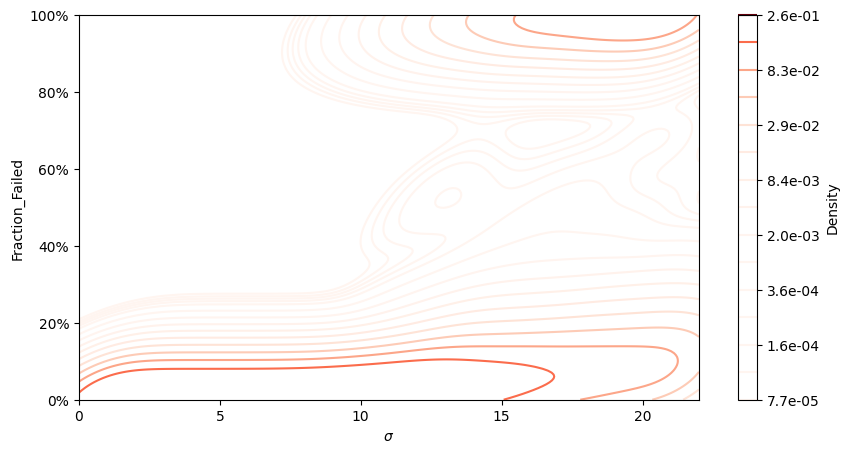

In [170]:
# Plot 2D-Histogram

# Extract plot data
indices_last_step_per_model = abm_df.groupby(["rep_id", "sigma"])["Step"].idxmax()
hist_df = abm_df.loc[indices_last_step_per_model]

# Plot
axes = kdeplot(x = hist_df.sigma, y = hist_df.Fraction_Failed, levels = logspace(-4, 0, num = 15),
               cut = 0, cmap = "Reds", cbar = True,
               cbar_kws = {"label": "Density", "format": "{x:.1e}"})
axes.set_xlabel(r"$\sigma$")
axes.xaxis.set_major_locator(MultipleLocator(5))
axes.yaxis.set_major_formatter(PercentFormatter(1))  # see: https://stackoverflow.com/a/36319915

Note that the density is bimodal for large $\sigma$!
This means that *either* very few *or* almost all agents fail in teams whose members are highly heterogeneous in their task-solving fitness, but partial team damage is rare.
The bimodal distribution is described in more detail in the paper.

## Systemic Risk Plot

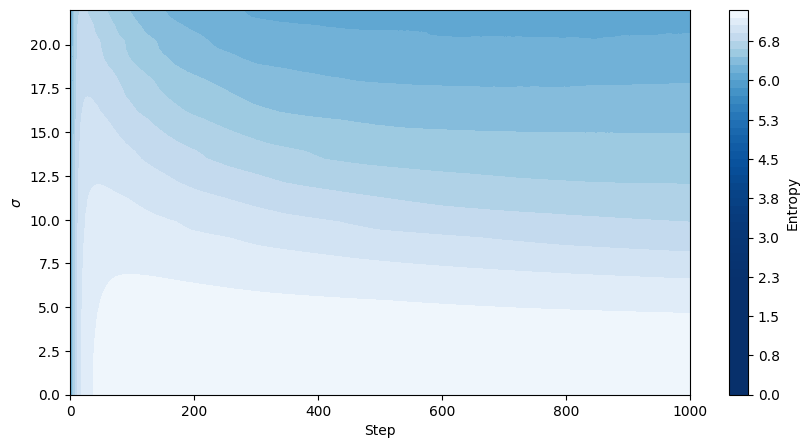

In [173]:
# Average values across repetitions

risk_df = abm_df[["sigma", "Step", "Matrix_Entropy"]].\
    groupby(["sigma", "Step"], as_index = False).\
    mean()

# Re-arrange into mesh-grid: rows=y-axis=sigma, cols=x-axis=Step
risk_df = risk_df.pivot(index = "sigma", columns = "Step", values = "Matrix_Entropy")

# Plot
fig, axes = subplots()
contour = axes.contourf(risk_df.columns, risk_df.index, risk_df,
                        levels = linspace(risk_df.min(axis = None), risk_df.max(axis = None), num = 50),
                        norm = PowerNorm(4),  # colors emphasize differences among entropies close to max
                        cmap = "Blues_r")
axes.set_xlabel("Step")
axes.set_ylabel(r"$\sigma$")
fig.colorbar(contour, label = "Entropy", format = "{x:.1f}");

Darker colors (= smaller entropies) mean stronger lock-in effects in the redistribution network of tasks among team members.
A lock-in means that team members have small circles of colleagues to whom they redistribute tasks.
I.e., they are not flexible in their choice to whom they assign tasks.
The plot shows that stronger lock-ins occur mainly for high values of $\sigma$.
The paper discusses this in more detail.